# Deep Explanation: Using AI for Explaining the Results of AI

Insights regarding the decisions of a deep learning model are obtained through perturbating its inputs. Importantly, the perturbations are extracted automatically by another deep neural network. Analysis of the perturbed inputs allows identifying what parts of the input are primarily responsible for the model output. This identification can then be leveraged to explain, in human terms, the model's response. The technique described here is implemented in [pytorch](https://pytorch.org/) and then applied to explaining the outputs of a standard image recognition model ([VGG19](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)).

## Outline

1. Introduction
2. Automatic perturbations
3. Pytorch implementation
4. Applications
5. Conclusions

# 1. Introduction

The application of complex machine learning algorithms to every day problems has achieved considerable [widespread success](https://www.forbes.com/sites/bernardmarr/2016/09/30/what-are-the-top-10-use-cases-for-machine-learning-and-ai/). The machine learning paradigm replaces 'hard coding' with the learning of patterns directly from data. The adoption of machine learning may be viewed as switching to a flexible experimental approach as opposed to a 'theoretical' one in which a programmer is expected to foresee all possible situations. A drawback of this new procedure is that the mechanisms by which the machine learning algorithm reaches a decision are [not necessarily well understood](https://www.technologyreview.com/s/604087/the-dark-secret-at-the-heart-of-ai/). Understanding the logic behind algorithmic outcomes is important for a variety of reasons. One of them is preventing the algorithm from learning non-generalizable artifacts only present in the particular data used to train the machine learning model. For example, image recognition algorithms may take advantage of describing text present on the sides of some photos. Thus, having little or no human supervision over what the model learns risks rendering parts of the models useless for practical applications. Moreover, due to the widespread use of machine learning algorithms [ethical concerns](https://abovethelaw.com/2018/04/ethical-considerations-for-artificial-intelligence/) have to be considered. If anti-discrimination laws ban individuals and companies from certain behaviors then any algorithm affecting society has to also comply with those rules. This matter is particularly pressing since the recent adoption by the European Union of new [data regulations](https://en.wikipedia.org/wiki/General_Data_Protection_Regulation). All the advantages and issues mentioned above have been greatly amplified by the widespread use of deep neural networks that allow a drastic increase in model complexity.

There have been many efforts for understanding the mechanisms behind machine learning and particularly deep learning algorithms. Indeed, shortly after the introduction of the [first](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) successful image recognition deep learning model, researchers devised a [perturbational approach](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) for revealing the model's inner workings. Other methods for understanding the model responses include the use of optimization algorithms (notably gradient descent since it is already built into neural networks due to their need for back-propagation) for finding the inputs that [optimally activate](https://ai.stanford.edu/~ang/papers/nips09-MeasuringInvariancesDeepNetworks.pdf) certain neurons within the model. [Recent](https://arxiv.org/abs/1704.03296) efforts have combined both approaches by seeking the extraction of optimum perturbations to the inputs that most effectively reduce a given model output. In the latter approach the perturbations are generated in part from a multiplicative mask that is then optimized by back propagation.

The present work builds on the [recent approach mentioned above](https://arxiv.org/abs/1704.03296) by allowing for more arbitrary perturbations that are automatically derived by a convolutional neural network (CNN) inserted into the process. The CNN's weights and biases for an optimal perturbation are also learned through back-propagation. The optimum perturbation is then analyzed for identifying input regions that are most important for the model's response. The identified important input regions can allow deducing intuitive interpretations of the model decisions.

# 2. Automatic perturbations

The technique for explaining the outcomes of a complex deep learning model M is described here. A [convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) is used for understanding the decisions of the trained model M. For a given input x0 to the model resulting in some top class ymax = M(x0)[k] (where k is the maximum class index), the CNN produces automatically an optimal perturbed input xpert = x0 + dx. The perturbated input xpert results in a maximal reduction of the formerly top class value, i.e., M(xpert)[k] << ymax. An optimum perturbation xpert_opt is obtained through optimizing the weights of the perturbing CNN model through a gradient descent algorithm based on gradient back-propagation. The particular model M studied here is the VGG19 model trained on the imagenet dataset for image recognition.

In the forward direction, the output after the CNN layers is scaled to resemble the original input's range. The resulted perturbed input xpert is then passed through M and its output score ypert = M(xpert)[k] is used for calculating the loss for back-propagation. The loss is given by ypert + l1_term, where l1_term is proportional to the difference between xpert and x0. Thus, the back-propagation process aims to reduce ypert while at the same time attempting to keep xpert as close as possible to x0. This is an important requirement for avoiding the optimization of artifacts. For instance, an optimum perturbation that minimizes ypert may be given by xpert equal to an image filled with zeroes.

A post-processing procedure is then performed for analyzing the results. This step roughly consists on a (nonlinear) comparison between x0 and xpert along with some image processing for highlighting the important differences. This allows identifying relevant regions in x0. The identified regions are shown below to lead to intuitive interpretations of what the VGG19 model considers important in classifying images.

# 3. Pytorch implementation

The details of the method outlined in Sec. 2 are presented through their implementation in [pytorch](https://pytorch.org/). The implementation below was inspired in part by the ideas discussed in [this paper](https://arxiv.org/abs/1704.03296) and its [pytorch implementation](https://github.com/jacobgil/pytorch-explain-black-box).

## 3.1 Preliminaries

Some needed imports first:

In [1]:
%matplotlib inline

import torch
from torchvision import models
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import transform
from skimage import morphology
from scipy.ndimage import center_of_mass
from tqdm import tqdm
import pickle

The warnings are sometimes distracting...

In [9]:
import warnings
warnings.filterwarnings('ignore')

some parameters that will be called along the way:

In [2]:
image_path="data/image_samples/cat.jpg"
kernel_size=3
nblocks=3
nlayers=3
epochs=1000
lr=0.01
l1_coeff=1.0
indicate_center_of_mass=True

and some helper functions:

In [12]:
def use_cuda():
    return torch.cuda.is_available()


def image_tensor_to_numpy(tensor):
    img = tensor.data.cpu().numpy()[0]
    img = np.transpose(img, (1, 2, 0))
    return img


def image_tensor_to_numpy(tensor):
    img = tensor.data.cpu().numpy()[0]
    img = np.transpose(img, (1, 2, 0))
    return img

## 3.2 Load the model (to be analyzed) and original image (to be perturbated)

### The model (M above):

In [5]:
def load_vgg_model():
    model = models.vgg19(pretrained=True)
    model.eval()

    if use_cuda():
        model.cuda()

    for p in model.features.parameters():
        p.requires_grad = False

    for p in model.classifier.parameters():
            p.requires_grad = False

    return model


vgg_model = load_vgg_model()
print vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

### The image (x0 above):

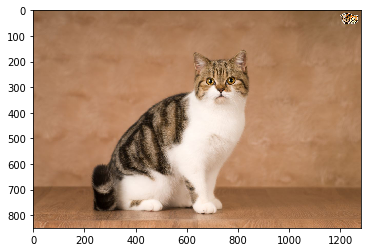

In [7]:
def load_image(image_path, graph=True):
    img = io.imread(image_path)

    if graph:
        plt.figure("original image")
        plt.imshow(img)

    return img


img = load_image(image_path)

## 3.3 Transform the image to torch tensor

The image (currently a numpy ndarray) is transformed to a torch tensor and scaled so as to have a range of values suitable as inputs to the vgg_model.

In [11]:
def image_to_vgg_input_tensor(img):
    preprocessed_img = transform.resize(img, (224, 224))
    preprocessed_img = np.float32(preprocessed_img.copy())
    preprocessed_img = preprocessed_img[:, :, ::-1]

    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    for i in range(3):
        preprocessed_img[:, :, i] =\
            preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] =\
            preprocessed_img[:, :, i] / stds[i]

    preprocessed_img = np.ascontiguousarray(
        np.transpose(preprocessed_img, (2, 0, 1))
    )

    if use_cuda():
        preprocessed_img_tensor =\
            torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor =\
            torch.from_numpy(preprocessed_img)

    preprocessed_img_tensor.unsqueeze_(0)

    return Variable(preprocessed_img_tensor, requires_grad = False)


img_tensor = image_to_vgg_input_tensor(img)
print type(img_tensor)
print img_tensor.shape

<class 'torch.Tensor'>
torch.Size([1, 3, 224, 224])


To visualize the scaling changes:

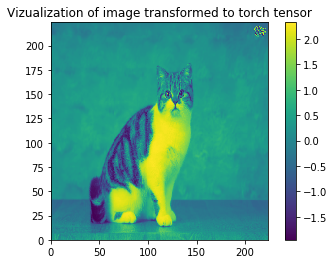

In [30]:
proc_img_np = image_tensor_to_numpy(img_tensor)
proc = np.mean(proc_img_np, axis=2) # to see in 2D plot average over the color values

plt.pcolormesh(proc[::-1, :])
plt.colorbar()
ax = plt.gca()
ax.set_aspect(1)
__ = plt.title("Vizualization of image transformed to torch tensor")

## 3.4 Assessing the model's performance on the image

In [15]:
def vgg_input_assessment(input_tensor, vgg_model):
    with open("data/imagenet1000_clsid_to_human.pkl", "r") as fp:
        vgg_class = pickle.load(fp)

    outputs = torch.nn.Softmax()(vgg_model(input_tensor))
    outputs_np = outputs.data.cpu().numpy()
    sorted_args = np.argsort(outputs_np[0, :])[::-1]

    print "5 top classes identified by the model:"
    print "(class index) class description: model score"

    for index in sorted_args[:5]:
        print "({}) {}: {}".format(index, vgg_class[index], outputs[0, index])

    print

    if outputs_np[0, sorted_args[0]] < 0.5:
        print "*** Warning ***"
        print "top category score under 0.5, extracted explanation may not be accurate on not well defined class"
        print
        
        
vgg_input_assessment(img_tensor, vgg_model)

5 top classes identified by the model:
(class index) class description: model score
(281) tabby, tabby cat: 0.802203714848
(282) tiger cat: 0.124585837126
(285) Egyptian cat: 0.0701399073005
(283) Persian cat: 0.00106593884993
(539) doormat, welcome mat: 0.000402584497351



## 3.5 Build the perturbations generator

For easy use of pytorch's gradient back-propagation, the perturbation is defined as a pytorch module.

In [16]:
class PerturbationsGenerator(torch.nn.Module):
    def __init__(self, kernel_size=3, nblocks=3, nlayers=3):
        super(PerturbationsGenerator, self).__init__()
        # build conv layers, implement padding='same':
        if np.mod(kernel_size, 2) == 0: kernel_size += 1
        padding = kernel_size // 2
        self.conv = torch.nn.Conv2d(
            3, 3, kernel_size = kernel_size,
            padding = padding,
        )
        self.relu = torch.nn.ReLU()
        self.nblocks = nblocks
        self.nlayers = nlayers

        if use_cuda(): self.cuda()

    def forward(self, x):
        # gather information for scaling
        xmin = torch.min(x)
        Dx = torch.max(x - xmin)

        # perturbate the image:
        for __ in range(self.nblocks):
            for __ in range(self.nlayers):
                x = self.conv(x)
            x = self.relu(x)

        # scale to original input range:
        x = x.add(- torch.min(x))  # x: zero to something
        x = x.div(torch.max(x))  # x: zero to 1
        x = x.mul(Dx)  # x: zero to Dx
        x = x.add(xmin)  # x: xmin to xmin + Dx

        if use_cuda(): x.cuda()

        return x
    

pert_model = PerturbationsGenerator(
    kernel_size, nblocks, nlayers,
)

As defined in the "forward" method, the input tensor goes through blocks of convolutional layers after which it is scaled to the range of the original input. This last step is important since the perturbed tensor x will be fed as input to vgg_model (and the original input has a suitable range for the vgg_model).

## 3.6 Find an optimum perturbation

The following back-propagates the gradient and runs gradient descent on a loss to find the CNN weights and biases that produce an optimum perturbation. The padding of the conv layers is set such that the layer output has the same shape as the input (similar to the padding="same" setting in keras). This is important since the tensor has to keep the same dimensions to act as a 'perturbation' of the input.

Since the CNN parameters were defined within a pytorch module using native functions, it is very simple to setup the optimizer on these parameters: torch.optim.Adam(pert_model.parameters(), lr).

The loss is defined as the value of the maximum class (for the original image) plus a measure of how different is the perturbed from the original image.

  0%|          | 4/1000 [00:00<00:29, 33.38it/s]

Category with highest probability 281
Optimizing.. 


100%|██████████| 1000/1000 [00:25<00:00, 39.33it/s]


original score: 0.802203714848
perturbed score: 0.000889057584573


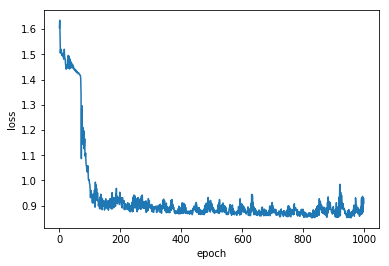

In [17]:
def get_optimum_perturbation(
        epochs, pert_model, img, vgg_model,
        lr=0.1, l1_coeff=0.01,
):
    optimizer = torch.optim.Adam(
        pert_model.parameters(), lr=lr
    )
    target = torch.nn.Softmax()(vgg_model(img))
    category = np.argmax(target.cpu().data.numpy())
    print "Category with highest probability", category
    print "Optimizing.. "
    losses = []

    for i in tqdm(range(epochs)):
        pert_img = pert_model(img)
        outputs = torch.nn.Softmax()(vgg_model(pert_img))
        img_diff = img - pert_img
        l1_term = l1_coeff * torch.mean(torch.abs(torch.pow(img_diff, 1)))
        loss = l1_term + outputs[0, category]
        losses.append(loss.data[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # plot the loss:
    plt.figure("loss")
    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("loss")

    print "original score: {}".format(torch.nn.Softmax()(vgg_model(img))[0, category])
    print "perturbed score: {}".format(torch.nn.Softmax()(vgg_model(pert_img))[0, category])

    return pert_img


pert_img_tensor = get_optimum_perturbation(
    epochs, pert_model, img_tensor,
    vgg_model=vgg_model,
    lr=lr, l1_coeff=l1_coeff,
)

The optimization drastically pushed down the vgg_model's score by three orders of magnitude. When one sees the loss history above during a common neural net training, one thing to do would be to increase the batch size (to make to curve less noisy). But here we are restricted to only one sample... The learning rate could be decreased, but going too far may end up with the optimizer not optimizing.

The optimum perturbated image is plotted along the original one next

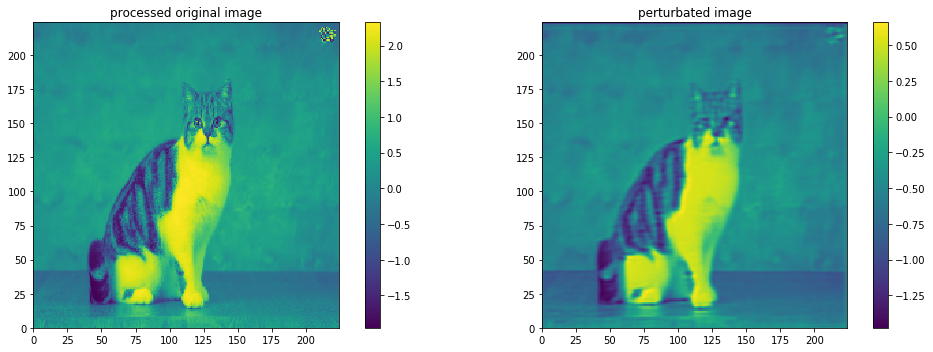

In [22]:
processed_img = image_tensor_to_numpy(img_tensor)
pert_img = image_tensor_to_numpy(pert_img_tensor)
proc = np.mean(processed_img, axis=2)
pert = np.mean(pert_img, axis=2)

fig, (ax1, ax2) = plt.subplots(
    ncols=2, figsize=(15, 5),
)
fig.canvas.set_window_title("images")

im1 = ax1.pcolormesh(proc[::-1, :])
fig.colorbar(im1, ax=ax1, fraction=0.046)
ax1.set_aspect(1)
ax1.set_title("processed original image")

im2 = ax2.pcolormesh(pert[::-1, :])
fig.colorbar(im2, ax=ax2, fraction=0.046)
ax2.set_aspect(1)
ax2.set_title("perturbated image")

fig.tight_layout()

As intended, the perturbated image does not diverge much from the original image. The image background is not affected that much by the perturbation while, on the other hand, the cat's features are blurred. The [paper cited above]() basically uses an optimized blurring mask to identify the important parts of the image. [The automatically derived perturbation here](https://github.com/roberto1648/deep-explanation-using-ai-for-explaining-the-results-of-ai/blob/master/deep_explanation.py) can customize the operations applied to the image (as opposed to only attenuating its pixels). Moreover, the convolutional layers may nonlinearly mix the pixels in producing the optimum perturbation.

Notice that the small cartoon at the upper right corner (that contains a cartoon cat face) has also been considerably modified by the perturbation.

## 3.7 Post-processing

In this step:
- The tensors are transformed from torch to numpy arrays.
- A power of the difference between the original and perturbated images is calculated and then processed to highlight the areas of the image that are seemingly most important in the vgg_model assigning a class to it. The difference is elevated here to a relatively high power (sixth). This works as a form of thresholding. Other powers may be used here for different models.
- Features too close to the edge of the image are removed. This is because of possible artifacts that may be introduced due to padding with zeroes during the convolution operations above. A drawback is that valid features close to the edges (e.g., as the inserted cat face at the upper right corner) can be missed. But in most cases of interest the main image class is well represented inside the image.

In [27]:
def post_processing(proc_img_tensor, pert_img_tensor):
    proc_img_np = image_tensor_to_numpy(proc_img_tensor)
    pert_img_np = image_tensor_to_numpy(pert_img_tensor)

    # mean over image channels:
    proc = np.mean(proc_img_np, axis=2)
    pert = np.mean(pert_img_np, axis=2)

    # highlighting the differences:
    diff = (proc - pert) ** 6

    # remove the edges: artifacts due to padding may appear.
    h, w = np.shape(diff)
    diff[:int(0.1 * h), :] = 0
    diff[int(0.9 * h):, :] = 0
    diff[:, :int(0.1 * w)] = 0
    diff[:, int(0.9 * w):] = 0

    # dilate the important points left for visibility:
    square = np.ones((20, 20))
    diff = morphology.dilation(diff, square)

    return diff, proc_img_np, pert_img_np


diff, proc_img_np, pert_img_np = post_processing(
    img_tensor, pert_img_tensor,
)

The extracted differences are plotted alongside the original and perturbed images:

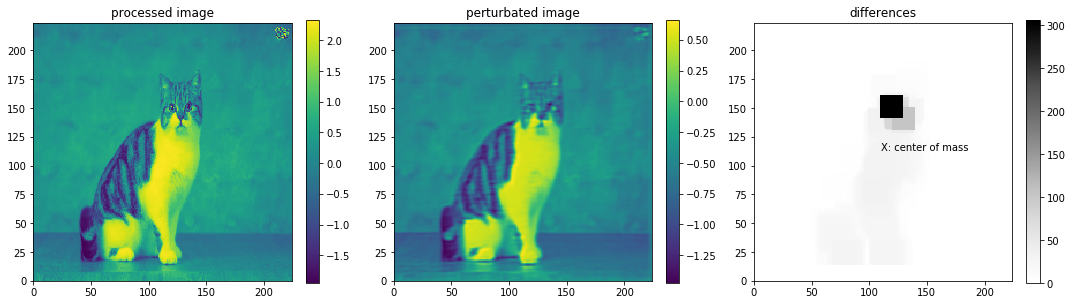

In [29]:
def plot_results(
    processed_img, pert_img, diff,
    indicate_center_of_mass=False,
):
    proc = np.mean(processed_img, axis=2)
    pert = np.mean(pert_img, axis=2)
    loc = center_of_mass(diff[::-1, :])

    fig, (ax1, ax2, ax3) = plt.subplots(
        ncols=3, figsize=(15, 5),
    )
    fig.canvas.set_window_title("images")

    im1 = ax1.pcolormesh(proc[::-1, :])
    fig.colorbar(im1, ax=ax1, fraction=0.046)
    ax1.set_aspect(1)
    ax1.set_title("processed image")

    im2 = ax2.pcolormesh(pert[::-1, :])
    fig.colorbar(im2, ax=ax2, fraction=0.046)
    ax2.set_aspect(1)
    ax2.set_title("perturbated image")

    im3 = ax3.pcolormesh(diff[::-1, :], cmap='Greys')
    fig.colorbar(im3, ax=ax3, fraction=0.046)
    ax3.set_aspect(1)
    ax3.set_title("differences")
    if indicate_center_of_mass:
        ax3.annotate("X: center of mass", loc)

    fig.tight_layout()
    plt.show()


plot_results(
    proc_img_np, pert_img_np, diff,
    indicate_center_of_mass=indicate_center_of_mass,
)

Notice how the cat body is roughly shaded in the differences plot. Also, the most important features are located by the cat's head. Also shown is the center of mass calculated from all points in the differences matrix. The center of mass could be used to give an approximated location of a class in an image with a single instance of it. In cases when many instances are present on the same image, a clustering algorithm could be used to find their places.

# 4. Applications

The program is now applied to several (i.e., cat and non-cat) [images](https://github.com/roberto1648/deep-explanation-using-ai-for-explaining-the-results-of-ai/tree/master/data/image_samples). All the functions above can be found in [deep_explanation.py](https://github.com/roberto1648/deep-explanation-using-ai-for-explaining-the-results-of-ai/blob/master/deep_explanation.py) along side the main() function that runs all the steps.

  0%|          | 5/1000 [00:00<00:24, 41.38it/s]

5 top classes identified by the model:
(class index) class description: model score
(285) Egyptian cat: 0.50977897644
(281) tabby, tabby cat: 0.208158865571
(282) tiger cat: 0.0818989351392
(904) window screen: 0.0630929172039
(905) window shade: 0.0317366085947

Category with highest probability 285
Optimizing.. 


100%|██████████| 1000/1000 [00:24<00:00, 41.28it/s]


original score: 0.50977897644
perturbed score: 0.00078588409815


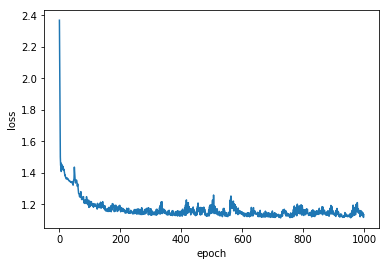

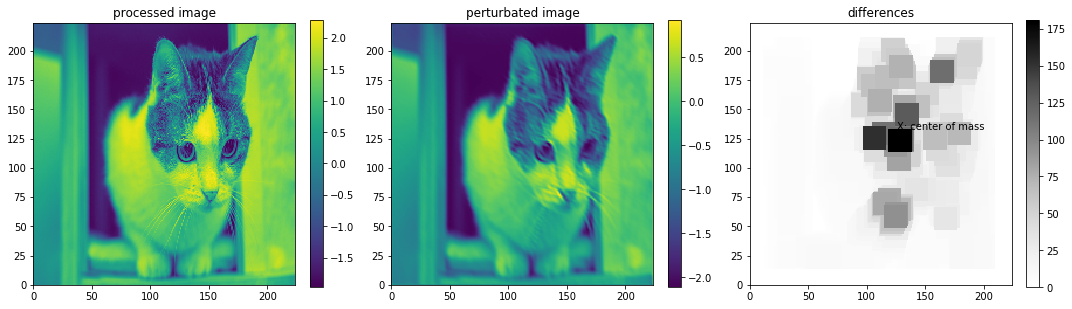

In [29]:
import deep_explanation

proc_img_np, pert_img_np, diff = deep_explanation.main(
    image_path="data/image_samples/cat2.jpg",
    kernel_size=3,
    nblocks=2,
    nlayers=3,
    epochs=1000,
    lr=0.01,
    l1_coeff=1.0,
    indicate_center_of_mass=True,
)

For some reason this cat image was problematic in other similar programs I have worked on before. The program performs reasonably well here.

  0%|          | 5/1000 [00:00<00:23, 41.78it/s]

5 top classes identified by the model:
(class index) class description: model score
(222) kuvasz: 0.823425173759
(257) Great Pyrenees: 0.141241371632
(207) golden retriever: 0.0236044339836
(208) Labrador retriever: 0.00311248097569
(229) Old English sheepdog, bobtail: 0.00158786645625

Category with highest probability 222
Optimizing.. 


100%|██████████| 1000/1000 [00:23<00:00, 41.67it/s]


original score: 0.823425173759
perturbed score: 0.000324941589497


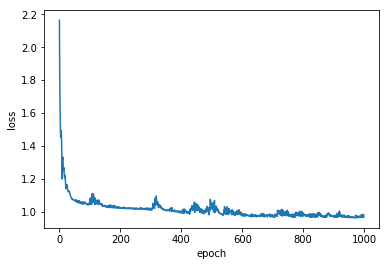

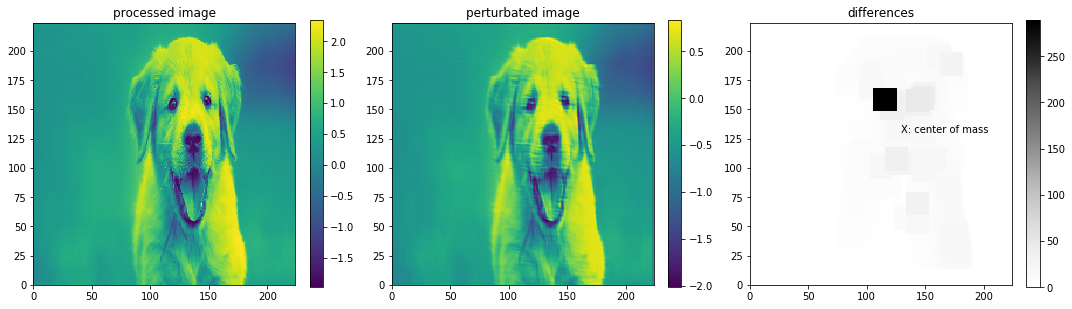

In [30]:
proc_img_np, pert_img_np, diff = deep_explanation.main(
    image_path="data/image_samples/dog.jpg",
    kernel_size=3,
    nblocks=2,
    nlayers=3,
    epochs=1000,
    lr=0.01,
    l1_coeff=1.0,
    indicate_center_of_mass=True,
)

The darkest point coincides with one of th eyes. Notice the horizontal striations inserted by the program on the puppy's face. The original image has one of such striations (by coordinates (110, 120)). It might be that the program used that as a suitable "seed" perturbation.

  0%|          | 5/1000 [00:00<00:24, 41.01it/s]

5 top classes identified by the model:
(class index) class description: model score
(817) sports car, sport car: 0.530656099319
(479) car wheel: 0.131468653679
(581) grille, radiator grille: 0.109313197434
(511) convertible: 0.103721126914
(436) beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon: 0.0631403699517

Category with highest probability 817
Optimizing.. 


100%|██████████| 1000/1000 [00:23<00:00, 42.38it/s]


original score: 0.530656099319
perturbed score: 0.00144367048051


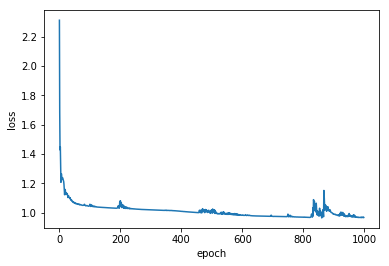

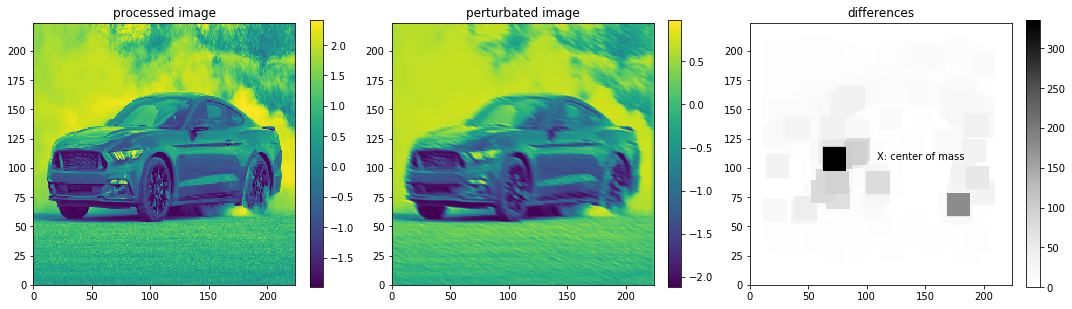

In [25]:
proc_img_np, pert_img_np, diff = deep_explanation.main(
    image_path="data/image_samples/car.jpg",
    kernel_size=3,
    nblocks=2,
    nlayers=3,
    epochs=1000,
    lr=0.01,
    l1_coeff=1.0,
    indicate_center_of_mass=True,
)

The darkest spot corresponds here to the headlight and there are other important points by the tires.

  0%|          | 5/1000 [00:00<00:24, 41.34it/s]

5 top classes identified by the model:
(class index) class description: model score
(517) crane: 0.965572297573
(913) wreck: 0.020407076925
(595) harvester, reaper: 0.00241595739499
(510) container ship, containership, container vessel: 0.00212941667996
(730) plow, plough: 0.000826664734632

Category with highest probability 517
Optimizing.. 


100%|██████████| 1000/1000 [00:24<00:00, 40.34it/s]


original score: 0.965572297573
perturbed score: 0.000938760233112


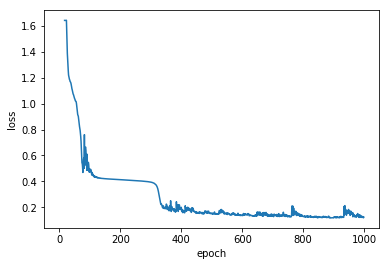

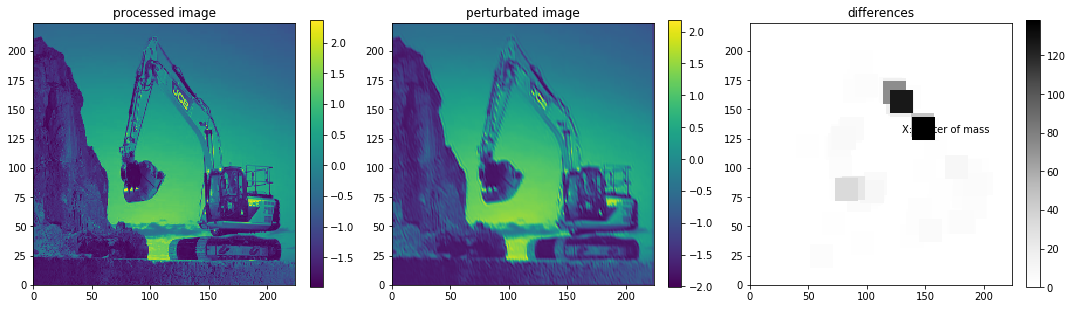

In [31]:
proc_img_np, pert_img_np, diff = deep_explanation.main(
    image_path="data/image_samples/excavator.jpg",
    kernel_size=3,
    nblocks=2,
    nlayers=3,
    epochs=1000,
    lr=0.01,
    l1_coeff=1.0,
    indicate_center_of_mass=True,
)

The arm of the excavator is highlighted here. Notice that the top class was supposed to be here "crane" in which case the arm would indeed be a more important feature.

  0%|          | 5/1000 [00:00<00:24, 40.33it/s]

5 top classes identified by the model:
(class index) class description: model score
(483) castle: 0.782301783562
(975) lakeside, lakeshore: 0.037042953074
(576) gondola: 0.0343679413199
(833) submarine, pigboat, sub, U-boat: 0.0290066376328
(536) dock, dockage, docking facility: 0.0265274904668

Category with highest probability 483
Optimizing.. 


100%|██████████| 1000/1000 [00:23<00:00, 41.82it/s]


original score: 0.782301783562
perturbed score: 0.0055736429058


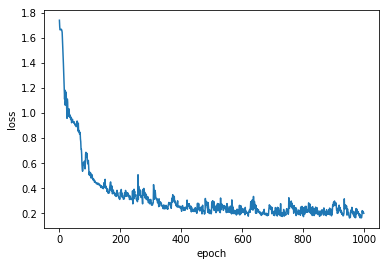

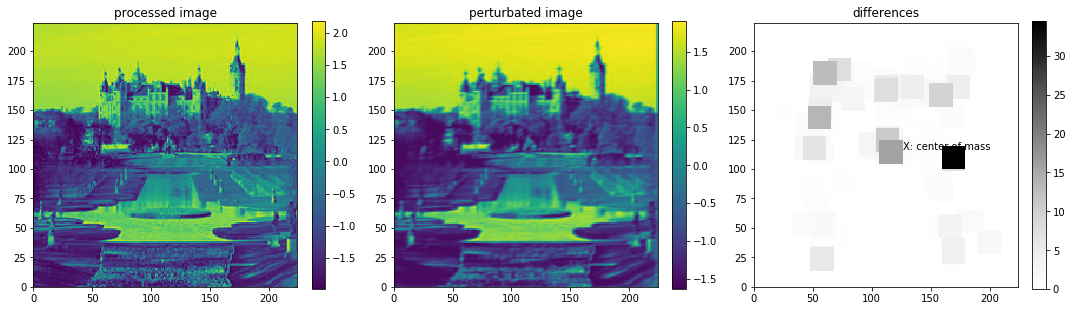

In [32]:
proc_img_np, pert_img_np, diff = deep_explanation.main(
    image_path="data/image_samples/palace.jpg",
    kernel_size=3,
    nblocks=2,
    nlayers=3,
    epochs=1000,
    lr=0.01,
    l1_coeff=1.0,
    indicate_center_of_mass=True,
)

One thing here is that it seems that many castles/palaces have stairs and some body of water around them. Still many relevant points group around the actual castle.

  0%|          | 4/1000 [00:00<00:25, 38.95it/s]

5 top classes identified by the model:
(class index) class description: model score
(644) matchstick: 0.356368899345
(401) accordion, piano accordion, squeeze box: 0.104134827852
(509) confectionery, confectionary, candy store: 0.0491409525275
(769) rule, ruler: 0.0386349000037
(868) tray: 0.0335290394723

*** Warning ***
top category score under 0.5, extracted explanation may not be accurate on not well defined class

Category with highest probability 644
Optimizing.. 


100%|██████████| 1000/1000 [00:26<00:00, 37.34it/s]


original score: 0.356368899345
perturbed score: 0.00428548082709


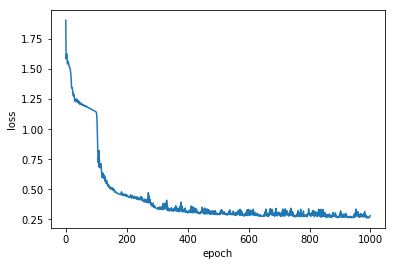

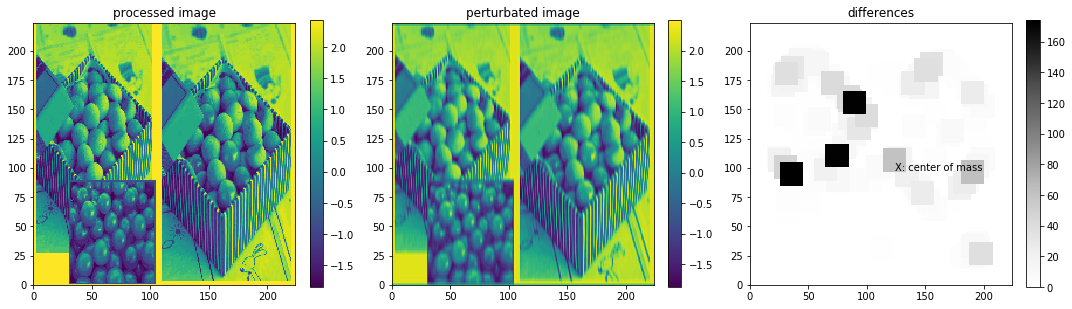

In [28]:
proc_img_np, pert_img_np, diff = deep_explanation.main(
    image_path="data/image_samples/image_admixture.gif",
    kernel_size=3,
    nblocks=3,
    nlayers=3,
    epochs=1000,
    lr=0.01,
    l1_coeff=1.0,
    indicate_center_of_mass=True,
)

This one was hard enough so as to confuse VGG (and trigger my little warning). Since the supposed highest class was "matchstick" here, the program highlighted the edges around two of the boxes in the image: the boxes' edges do resemble matches.

As seen in the examples above, the program not only roughly finds the area occupied by the top class, but also points to individual features of the located object. In the case of VGG19 the highlighted features both make intuitive sense and confirm the quality of the model.

# 5. Conclusions

An algorithm was developed for extracting information about the criteria used by an image recognition model in classifying images. The algorithm finds an optimum perturbation that minimizes the top class score while attempting to keep the image as close as possible to the original image. Importantly, the perturbations are designed by a convolutional neural network (CNN) whose weights are optimized to produce the optimum perturbation. The use of a CNN for generating perturbations allows for a variety of nonlinear perturbations that are customized to the particular image.

Highlighting the important parts of the inputs made intuitive sense in the case of images. Similarly, for text or video models the program may be able to highlight crucial words or features in particular frames, respectively.

Due to the reliance on pytorch's built-in back-propagation, the particular implementation given here is limited to analyzing models implemented in pytorch. The number of such models is currently growing along with pytorch's popularity. It might be possible to analyze other (i.e., not implemented yet in pytorch) models by sampling the class scores for various images such that an approximate linear inverse model could be obtained. This can then be used to define the "backward" method of the model in pytorch.